In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/IP2Vec')

%cd /content/drive/My Drive/Colab Notebooks/IP2Vec

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/IP2Vec


dfかcsvを読み込む部分、他の人間やpcでも同じように実行できるようにしておきたい



In [2]:
import pandas as pd

data_path = "modified_botnet_first1000rows.csv"
df = pd.read_csv(data_path)
print(df)

            Source    Destination Protocol  Source Port  Destination Port
0    60.190.223.75  147.32.84.165      TCP       2012.0            1048.0
1    60.190.223.75  147.32.84.165      TCP       2012.0            1048.0
2    147.32.84.165  60.190.223.75      TCP       1048.0            2012.0
3    147.32.84.165  60.190.223.75      TCP       1048.0            2012.0
4    60.190.223.75  147.32.84.165      TCP       2012.0            1048.0
..             ...            ...      ...          ...               ...
995  113.70.243.53  147.32.84.208      RDP       3906.0            3389.0
996  147.32.84.208  113.70.243.53      RDP       3389.0            3906.0
997  147.32.84.208  113.70.243.53      TCP       3389.0            3906.0
998  147.32.84.208  113.70.243.53      RDP       3389.0            3906.0
999  147.32.84.208  113.70.243.53      TCP       3389.0            3906.0

[1000 rows x 5 columns]


In [3]:
from tqdm import tqdm_notebook as tqdm
def _w2v(data):
    w2v ={}
    v2w = {}
    fla_d = data.flatten()
    for i in tqdm(fla_d):
        if i not in w2v:
            w2v[i] = len(w2v)
            v2w[len(w2v)-1] = i

    return w2v,v2w

def _corpus(data,w2v):
    corpus = [[w2v[w] for w in ww]  for ww in tqdm(data)]
    return corpus

def _frequency(data):
    freq = {}
    fla_d = data.flatten()
    for w in tqdm(fla_d):
        if w not in freq:
            freq[w] = 0
        freq[w] += 1
    return freq
def _data_loader(corpus,batch_size):

    def func(x):
        return [[x[0],x[1]],[x[0],x[2]],[x[0],x[3]],[x[2],x[1]],[x[3],x[1]]]

    def flatten(nested_list):
        return [e for inner_list in nested_list for e in inner_list]


    l = [func(x) for x in tqdm(corpus)]
    del corpus
    return l
    #l = pd.DataFrame(flatten(l)).to_numpy()
    #batch = [l[batch_size*(i-1):batch_size*i] for i in tqdm(range(1,int(len(l)/batch_size)))]
    #return batch

In [4]:
import torch as th
from torch.autograd import Variable as V
from torch import nn,optim
import numpy as np
import random

class Skipgram(nn.Module):
    def __init__(self,vocab_size,emb_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.u_embedding = nn.Embedding(vocab_size,emb_dim)
        self.v_embedding = nn.Embedding(vocab_size,emb_dim)
        self.log_sigmoid = nn.LogSigmoid()

        init_range= 0.5/emb_dim
        self.u_embedding.weight.data.uniform_(-init_range,init_range)
        self.v_embedding.weight.data.uniform_(-0,0)

    def forward(self, target, context,neg):
        v_embedd = self.u_embedding(target)
        u_embedd = self.v_embedding(context)
        positive = self.log_sigmoid(th.sum(u_embedd * v_embedd, dim =1)).squeeze()

        u_hat = self.v_embedding(neg)
        #negative_ = th.bmm(u_hat, v_embedd.unsqueeze(2)).squeeze(2)
        negative_ = (v_embedd.unsqueeze(1) * u_hat).sum(2)
        negative = self.log_sigmoid(-th.sum(negative_,dim=1)).squeeze()

        loss = positive + negative
        return -loss.mean()


In [6]:
import torch as th
from torch.autograd import Variable as V
from torch import nn,optim
from tqdm import tqdm_notebook as tqdm
import numpy as np
import random
# from model import Skipgram
class Trainer:
    def __init__(self,w2v,v2w,freq,emb_dim):
        self.v2w = v2w
        self.w2v = w2v
        self.unigram_table = self.noise(w2v,freq)
        self.vocab_size = len(w2v)
        self.model = Skipgram(self.vocab_size,emb_dim).to(device)
        self.optim = optim.Adam(self.model.parameters())

    def noise(self,w2v, freq):
        unigram_table = []
        total_word = sum([c for c in freq.values()])
        for w,v in w2v.items():
            unigram_table.extend([v]*int(((freq[w]/total_word)**0.75)/0.001))
        return unigram_table

    def negative_sampling(self,batch_size,neg_num,batch_target):
        neg = np.zeros((neg_num))
       # print("neg:", neg)
       # for i in range(batch_size):
        for i in range(len(batch_target)):
            sample = random.sample(self.unigram_table, neg_num)
           # print("sample:", sample)
            while batch_target[i] in sample:
                sample = random.sample(self.unigram_table, neg_num)
            neg = np.vstack([neg,sample])
        return neg[1:batch_size+1]

    def fit(self,data,max_epoch,batch_size,neg_num):
        run_losses = []
        for epoch in range(max_epoch):
            run_loss = 0

           # print(data)
            for batch in tqdm(data):

                batch = np.array(batch)  # batchをlistからnumpyのndarrayに変換
               # print("batch:", batch)
                context,target = batch[:,1],batch[:,0]
               # print("context =", context,"target =" , target)
                self.optim.zero_grad()
                batch_neg = self.negative_sampling(batch_size,neg_num,target)
                context = V(th.LongTensor(context)).to(device)
                target = V(th.LongTensor(target)).to(device)
                batch_neg = V(th.LongTensor(batch_neg.astype(int))).to(device)

                loss = self.model(target, context, batch_neg)
                loss.backward()
                self.optim.step()
                run_loss += loss.cpu().item()
            run_losses.append(run_loss/len(data))
            print("epoch:", epoch,"run_loss:", run_loss)
        return run_losses
    def most_similar(self,word,top):
        W = self.model.state_dict()["u_embedding.weight"]
        idx = w2v[word]
        similar_score = {}
        for i,vec in enumerate(W):
            if i != idx:
                d = vec.dot(W[idx])
                similar_score[self.v2w[i]] = d
        similar_score = sorted(similar_score.items(), key=lambda x: -x[1])[:top]
        for k,v in similar_score:
            print(k,":",round(v.item(),2))


In [8]:
import numpy as np
import pandas as pd
#import preprocess as p
#import trainer as t

batch_size = 1024
path = "modified_botnet_first1000rows.csv"
X = pd.read_csv(path)
d = X.to_numpy()
w2v,v2w = _w2v(d)
corpus = pd.DataFrame(_corpus(d, w2v)).to_numpy()
print(corpus)
freq  = _frequency(d)
print(freq)
train = _data_loader(corpus, batch_size)
print(train)

model = Trainer(w2v,v2w,freq,emb_dim=32)
model.fit(data = train,max_epoch=50,batch_size=256,neg_num=10)
th.save(model.model.state_dict(),'ip2vec1000.pth')

<ipython-input-3-8bc80117c120>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(fla_d):


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-3-8bc80117c120>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  corpus = [[w2v[w] for w in ww]  for ww in tqdm(data)]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[  0   1   2   3   4]
 [  0   1   2   3   4]
 [  1   0   2   4   3]
 ...
 [  5   6   2   8 190]
 [  5   6  22   8 190]
 [  5   6   2   8 190]]


<ipython-input-3-8bc80117c120>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for w in tqdm(fla_d):


  0%|          | 0/5000 [00:00<?, ?it/s]

{'60.190.223.75': 139, '147.32.84.165': 697, 'TCP': 794, 2012.0: 43, 1048.0: 43, '147.32.84.208': 273, '113.70.243.53': 273, 'TPKT': 23, 3389.0: 273, 3719.0: 94, '147.32.80.9': 29, 'DNS': 29, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, '195.88.191.59': 167, 1049.0: 69, 80.0: 251, 'HTTP': 25, 'RDP': 85, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, '94.63.150.63': 70, 1052.0: 25, nan: 1, nan: 1, 1053.0: 13, 888.0: 47, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 1054.0: 59, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, '122.224.6.164': 212, 1055.0: 212, 82.0: 212, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 1056.0: 15, 'T.125': 12, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 1057.0: 17, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, '174.123.157.154': 14, 1058.0: 14, 1059.0: 17, nan: 1, nan: 1, nan: 1, nan: 1, 1060.0: 15, nan: 1, nan: 1, 1061.0: 49, 2011.0: 49, 3813.0: 155, 1062.0: 39, 'COTP': 2, 1063.0:

<ipython-input-3-8bc80117c120>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  l = [func(x) for x in tqdm(corpus)]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[0, 1], [0, 2], [0, 3], [2, 1], [3, 1]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[1, 0], [1, 2], [1, 4], [2, 0], [4, 0]], [[0, 1], [0, 2], [0, 3], [2, 1], 

<ipython-input-6-4f8963a4d487>:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(data):


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 run_loss: 922.3634813129902


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 1 run_loss: 646.253622174263


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 2 run_loss: 491.7931195497513


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 3 run_loss: 390.4162982031703


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 4 run_loss: 330.5514242425561


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 5 run_loss: 282.3479219209403


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 6 run_loss: 259.0351423509419


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 7 run_loss: 210.17838363535702


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 8 run_loss: 189.712019411847


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 9 run_loss: 167.98667426221073


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 10 run_loss: 148.53677049092948


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 11 run_loss: 144.23779298411682


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 12 run_loss: 115.98816337483004


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 13 run_loss: 98.4594630044885


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 14 run_loss: 97.48813429055735


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 15 run_loss: 87.88264732481912


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 16 run_loss: 92.205862471601


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 17 run_loss: 86.94640140770935


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 18 run_loss: 82.95302294567227


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 19 run_loss: 78.33276904351078


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 20 run_loss: 62.69919745950028


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 21 run_loss: 70.36333702364936


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 22 run_loss: 87.1482653117273


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 23 run_loss: 59.25436628237367


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 24 run_loss: 53.37303199060261


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 25 run_loss: 76.3743313853629


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 26 run_loss: 93.95443428936414


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 27 run_loss: 45.098716529784724


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 28 run_loss: 47.98697048658505


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 29 run_loss: 57.22211458906531


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 30 run_loss: 69.89240666548721


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 31 run_loss: 52.48391313571483


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 32 run_loss: 30.985765099641867


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 33 run_loss: 47.24372019607108


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 34 run_loss: 65.91976918635191


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 35 run_loss: 48.54891084949486


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 36 run_loss: 57.82527435955126


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 37 run_loss: 53.064120491966605


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 38 run_loss: 41.16246083867736


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 39 run_loss: 50.78226298530353


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 40 run_loss: 68.86466997337993


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 41 run_loss: 48.42722398095066


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 42 run_loss: 42.93640270375181


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 43 run_loss: 46.57680257118773


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 44 run_loss: 69.16438364138594


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 45 run_loss: 64.6694836523966


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 46 run_loss: 65.02944723906694


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 47 run_loss: 43.68354224553332


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 48 run_loss: 33.899345113604795


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 49 run_loss: 45.152132663992234


In [ ]:
model.most_similar("60.190.223.75",10)

195.88.191.59 : 30.88
122.224.6.164 : 30.67
80.0 : 27.23
94.63.150.63 : 23.72
82.0 : 23.66
888.0 : 20.09
2011.0 : 18.22
147.32.84.208 : 17.41
2012.0 : 17.29
147.32.84.165 : 15.2


In [10]:
model.most_similar("60.190.223.75",10)

195.88.191.59 : 32.51
94.63.150.63 : 26.87
122.224.6.164 : 25.22
82.0 : 25.01
80.0 : 24.96
147.32.84.165 : 22.02
888.0 : 19.55
DNS : 17.99
2011.0 : 17.4
2012.0 : 15.89


In [9]:
print(model.model.state_dict())

OrderedDict([('u_embedding.weight', tensor([[ 8.0619e-01,  1.2904e+00,  1.2014e-02,  ...,  3.6413e-01,
         -4.3972e-01, -2.3468e+00],
        [ 3.7984e-01,  9.4941e-01, -3.7247e-01,  ...,  4.6918e-01,
          1.2446e+00, -4.6544e+00],
        [-8.6303e-01,  2.1958e+00,  3.9399e+00,  ..., -3.3322e+00,
          3.3429e+00,  1.2942e-02],
        ...,
        [-6.9870e-01, -1.7557e-01, -2.2644e-01,  ..., -8.0708e-01,
         -1.4403e-01,  1.8050e-01],
        [-9.3907e-04,  1.6494e-03, -1.2617e-02,  ..., -9.3735e-03,
          1.1919e-02, -1.1132e-02],
        [-1.0962e+00,  1.3794e-01,  1.4773e+00,  ..., -8.7033e-01,
          3.1120e-01,  4.0631e-01]])), ('v_embedding.weight', tensor([[ 0.7548,  0.0020, -0.0484,  ..., -0.0069,  0.1676, -0.0854],
        [ 0.4592,  0.4918,  0.1759,  ..., -0.0207,  0.1619, -0.2470],
        [ 0.2128, -0.3254, -0.4660,  ...,  1.5347, -0.2562, -0.2032],
        ...,
        [-0.3621, -0.6859, -0.5987,  ..., -0.3755, -0.6225,  0.2113],
        [ 0.31

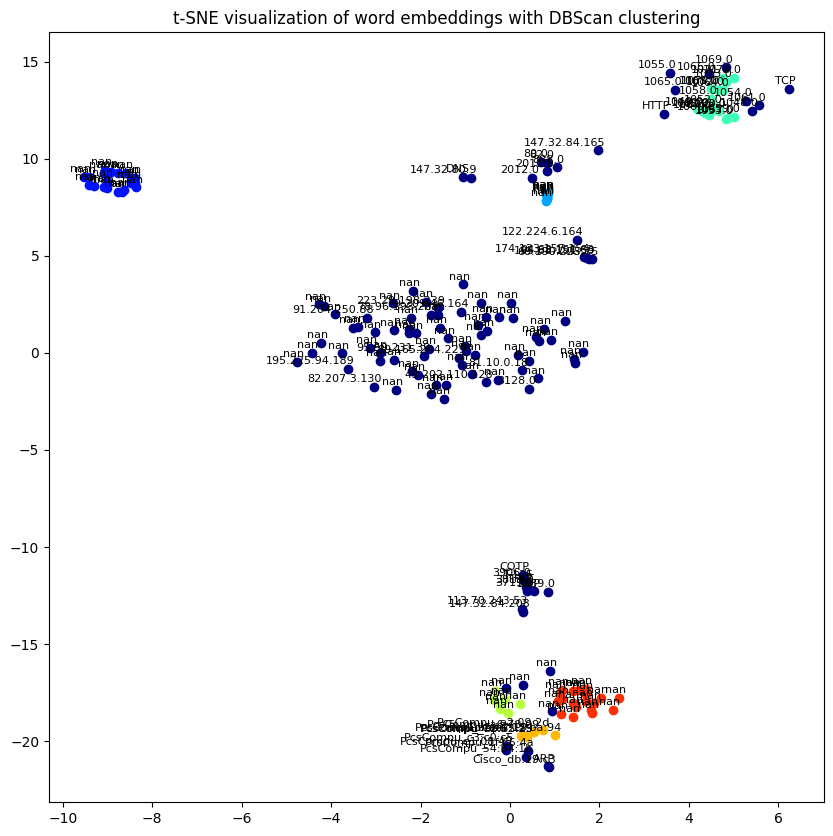

In [11]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. 学習された分散表現を取得
embeddings = model.model.u_embedding.weight.cpu().detach().numpy()

# 2. t-SNEを使用して次元削減
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# 3. DBScanを使用してクラスタリング
clustering = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_2d)
labels = clustering.labels_

# 4. matplotlibを使用して可視化
plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
    x, y = embeddings_2d[i]
    plt.scatter(x, y, color=plt.cm.jet(float(label) / np.max(labels + 1)))
    plt.annotate(v2w[i], xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE visualization of word embeddings with DBScan clustering')
plt.show()
